In [1]:
import os
%pwd

'c:\\projects\\LLM-Text-Detection\\notebook'

In [2]:
os.chdir('../')
%pwd

'c:\\projects\\LLM-Text-Detection'

### Import Libraries and dependencies

In [3]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud

### Load and read the datasets

In [4]:
df1 = pd.read_csv('notebook/data/train_v2.csv')

df1.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [5]:
df2 = pd.read_csv('notebook/data/train.csv')

df2.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


### Plot the datasets to see the distribution of the human and AI generated texts

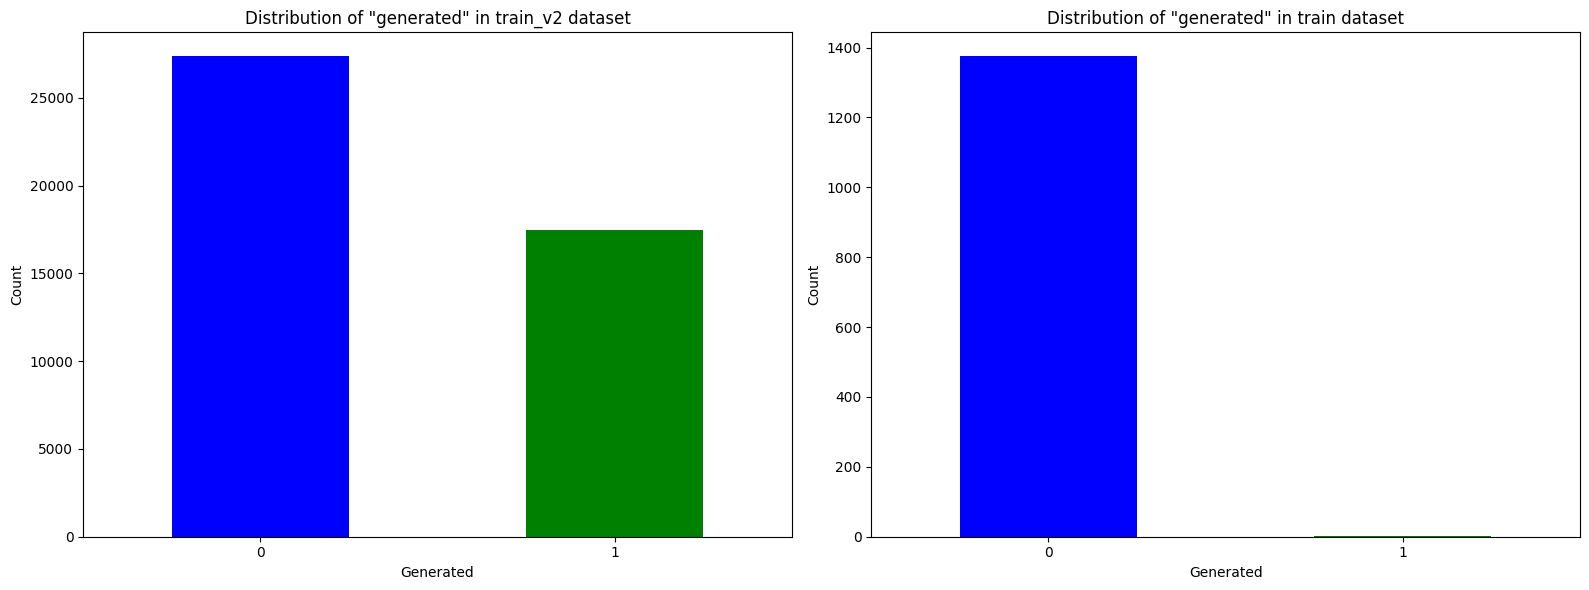

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for train_v2 dataset on the first subplot
df1['label'].value_counts().plot(
    kind='bar', 
    color=['blue', 'green'], 
    ax=axes[0]
)
axes[0].set_title('Distribution of "generated" in train_v2 dataset')
axes[0].set_xlabel('Generated')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(df1['label'].value_counts())))
axes[0].set_xticklabels(df1['label'].value_counts().index, rotation=0)

# Plot for train dataset on the second subplot
df2['generated'].value_counts().plot(
    kind='bar', 
    color=['blue', 'green'], 
    ax=axes[1]
)
axes[1].set_title('Distribution of "generated" in train dataset')
axes[1].set_xlabel('Generated')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(df2['generated'].value_counts())))
axes[1].set_xticklabels(df2['generated'].value_counts().index, rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

### Combining the Datasets

In [7]:
# Selecting necessary columns from train dataset
df11 = df1[['text', 'label']].copy()

# Selecting necessary columns from train_1 dataset and renaming 'generated' to match the 'label' column
df21 = df2[['text', 'generated']].rename(columns={'generated': 'label'}).copy()

# Concatenating the selected columns from both datasets
df = pd.concat([df11, df21], ignore_index=True)

# Displaying the combined data
print(df.shape)
df.head()

(46246, 2)


,text,label
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


### Distribution of the class in the combined dataset

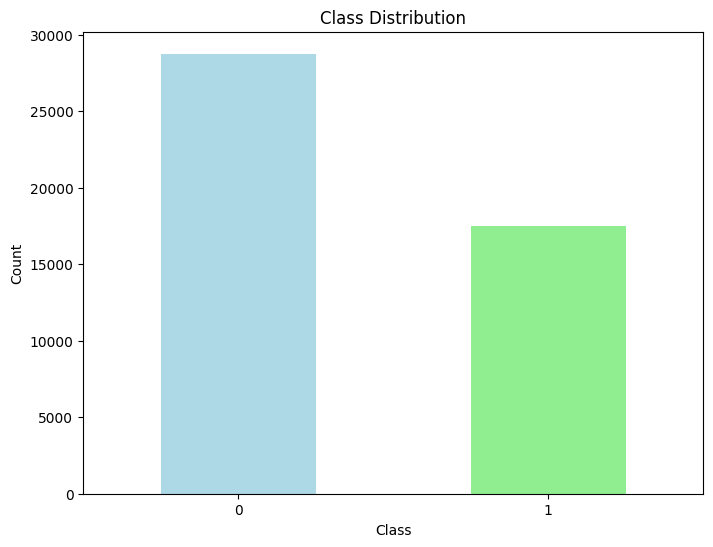

In [8]:
# Calculate class distribution
class_distribution = df['label'].value_counts()

# Plotting the class distribution as a bar chart
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.show()

### Cleaning the Dataset and Rechecking Class Distribution

* Checking for duplicates in combined data

In [9]:
# Checking for duplicates in combined data
duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
                                                    text  label
44868  Cars. Cars have been around since they became ...      0
44869  Transportation is a large necessity in most co...      0
44870  "America's love affair with it's vehicles seem...      0
44871  How often do you ride in a car? Do you drive a...      0
44872  Cars are a wonderful thing. They are perhaps o...      0
...                                                  ...    ...
46241  There has been a fuss about the Elector Colleg...      0
46242  Limiting car usage has many advantages. Such a...      0
46243  There's a new trend that has been developing f...      0
46244  As we all know cars are a big part of our soci...      0
46245  Cars have been around since the 1800's and hav...      0

[1378 rows x 2 columns]


* Dropping duplicates from combined data

In [10]:
# Dropping duplicates from combined data
df.drop_duplicates(inplace=True)

* Checking for null values in combined data

In [11]:

# Checking for null values in combined data
null_values = df.isnull().sum()
print("\nNull Values:")
print(null_values)


Null Values:
text     0
label    0
dtype: int64


* Confirming the removal of duplicates

In [12]:
# Confirming the removal of duplicates
print("\nAfter Dropping:")
print(df.shape)


After Dropping:
(44868, 2)


* Save the clean-combined DataFrame as a CSV file

In [13]:
# Save the combined DataFrame as a CSV file
csv_filename = 'LLM-Text-Detection-data.csv'
df.to_csv(csv_filename, index=False)

# Zip the CSV file
#zip_filename = 'LLM-Text-Detection-data.zip'
#with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    #zipf.write(csv_filename)

# Optionally, remove the CSV file if you only want the zip file
#os.remove(csv_filename)

#print(f'{zip_filename} created successfully.')

* Class distribution after dropping the duplicates

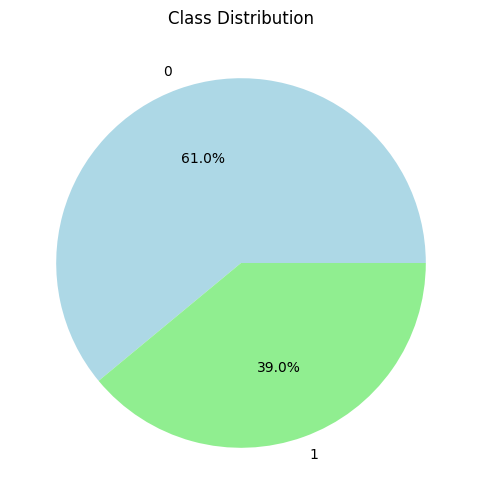

In [14]:
# Calculate class distribution
class_distribution = df['label'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, 
        autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.show()

### Word Cloud for the Classes

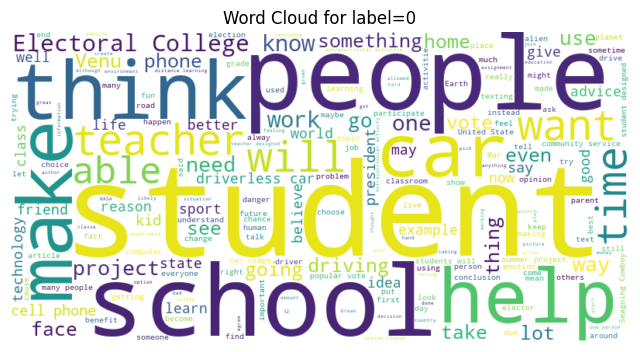

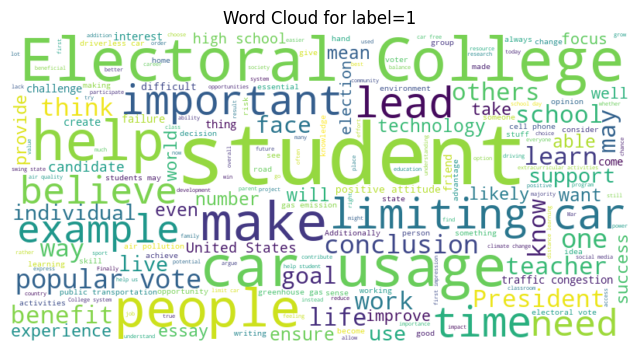

In [15]:
# Filter the combined data based on label values
label_0 = ' '.join(df[df11['label'] == 0]['text'])
label_1 = ' '.join(df[df['label'] == 1]['text'])

# Generate word clouds
wordcloud_0 = WordCloud(
    width=800, height=400, 
    background_color='white').generate(label_0)
wordcloud_1 = WordCloud(
    width=800, height=400, 
    background_color='white').generate(label_1)


# Plotting word cloud for label=0
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Word Cloud for label=0')
plt.axis('off')
plt.show()

# Plotting word cloud for label=1
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for label=1')
plt.axis('off')
plt.show()

### Vectorization with TF-IDF Vectorizer

In [16]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Tokenize and create TF-IDF vectors for the 'text' column of the combined dataset
tfidf_vectors = tfidf_vectorizer.fit_transform(df['text'])

# Convert TF-IDF vectors to a DataFrame for easy analysis
tfidf_df = pd.DataFrame(
    tfidf_vectors.toarray(), 
    columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame
print(tfidf_df.head())

    00       000   10  100   11  114  118   12   13   14  ...      your  \
0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.193019   
2  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
3  0.0  0.060816  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

   yours  yourself  youth  youtube  zip  zone  zones  zoos  zygomatic  
0    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
1    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
2    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
3    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
4    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  

[5 rows x 5000 columns]


###  Splitting the Dataset: split the dataset into 80–20 split for training and testing.

In [17]:
# Split the data into training and testing sets
X = tfidf_df.values  # Features (TF-IDF vectors)
y = df['label'].values  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=4)

### Label Encoding: label the classes

In [18]:
# Encode target labels (0 and 1) using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Building the Model

In [19]:
# Build a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Training the model

In [20]:
# Train the model
history = model.fit(
    X_train, 
    y_train_encoded, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test, y_test_encoded), 
    verbose=1)

Epoch 1/10
1122/1122 [==============================] - 17s 14ms/step - loss: 0.0495 - accuracy: 0.9812 - val_loss: 0.0143 - val_accuracy: 0.9953
Epoch 2/10
1122/1122 [==============================] - 15s 13ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0143 - val_accuracy: 0.9945
Epoch 3/10
1122/1122 [==============================] - 15s 13ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0207 - val_accuracy: 0.9944
Epoch 4/10
1122/1122 [==============================] - 13s 12ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0236 - val_accuracy: 0.9944
Epoch 5/10
1122/1122 [==============================] - 12s 11ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0319 - val_accuracy: 0.9939
Epoch 6/10
1122/1122 [==============================] - 12s 11ms/step - loss: 9.8462e-04 - accuracy: 0.9996 - val_loss: 0.0290 - val_accuracy: 0.9949
Epoch 7/10
1122/1122 [==============================] - 12s 11ms/step - loss: 4.5879e-04 - accuracy: 0.9999 - val_loss: 

### Evaluating the Model: Evaluate the model's performance on the test dataset using the trained model

* Accuracy

In [21]:
# Evaluate the model on the test set: Accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

281/281 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.9939
Test Accuracy: 0.9939


* Predict probabilities

In [22]:
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

281/281 [==============================] - 1s 3ms/step



* ROC-AUC score

In [23]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9998


* Classification report

In [24]:
# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5528
           1       0.99      1.00      0.99      3446

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



* Classification report heatmap

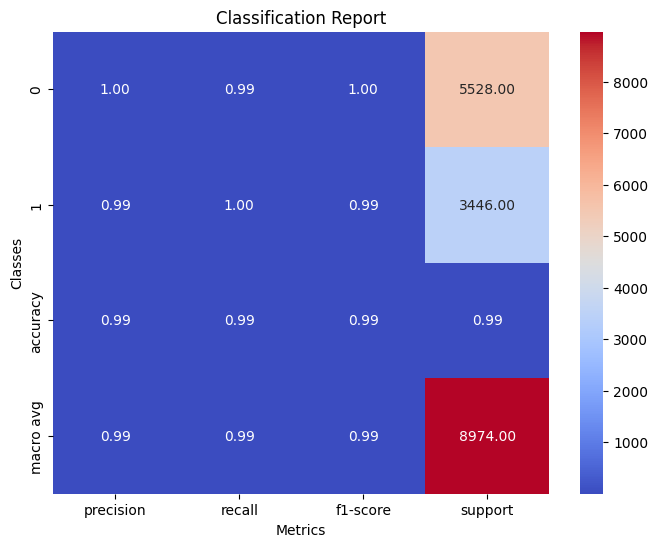

In [25]:
# Calculate classification report
report = classification_report(y_test_encoded, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

* Confusion matrix

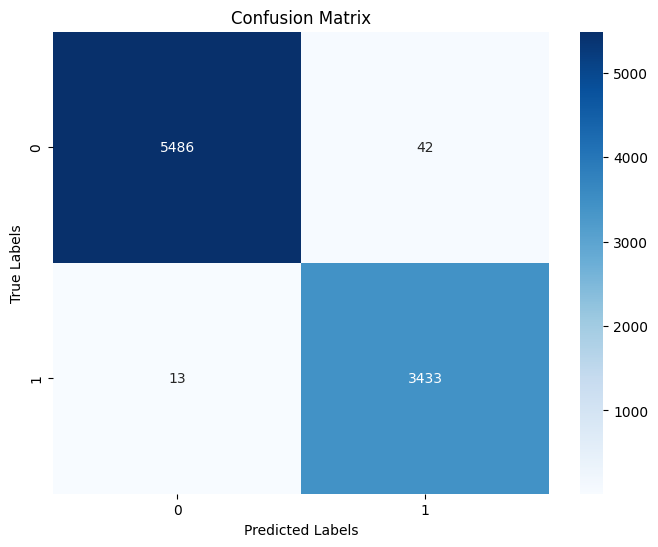

In [26]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Saving the Model and Tokenizer: Let’s save the model and tokenizer for future use.

In [27]:
import pickle

# Save the TF-IDF tokenizer in the 'notebook'
with open('notebook/tfidf_tokenizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
    
# Save the trained model
model.save('notebook/text_classification_model.keras')

In [29]:
import pandas as pd

df = pd.read_csv('LLM-Text-Detection-data.csv')
df_reduced = df.sample(n=40000, random_state=1)
print(df_reduced.shape)

(40000, 2)


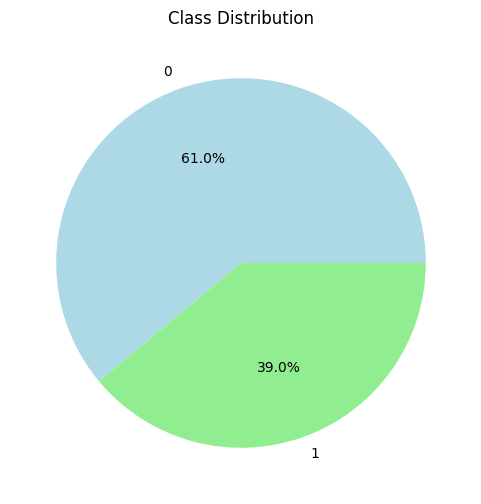

In [30]:
# Calculate class distribution
class_distribution = df_reduced['label'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, 
        autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.show()

In [31]:
df_reduced.to_csv('llm_text_detection_data.csv', index=False)

In [32]:
df_reduced.head()

,text,label
16750,My position on driverless cars is I think they...,0
43217,Cars have been part of our daily lives for dec...,0
25569,"Getting advice from multiple people is great, ...",0
18847,Getting rid of the electoral college would be ...,0
22981,"Throughout my life, I have wondered what it wo...",0
